# Eval 1: Expression Prediction

**Biological question**: Can we predict the gene expression profile after a perturbation?

**Metrics**: MSE, Pearson R (Top 20 DEGs), R² (All genes), R² (Top 50 DEGs)

**Story**: This is the core task - given a control cell and a perturbation, predict the resulting gene expression.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

from eval_common import EvalContext, update_eval_report

random.seed(1337)

In [2]:
ctx = EvalContext()
results = ctx.run_test_inference()

using cpu
Input Bank (DNA): torch.Size([1250, 1536])
<All keys matched successfully>
Decoder loaded
found 4 shards for split test
loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0001.npz


Running inference:  26%|███████▋                      | 312/1213 [01:42<05:55,  2.53it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0000.npz


Running inference:  52%|███████████████▍              | 625/1213 [04:28<05:01,  1.95it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0003.npz


Running inference:  74%|██████████████████████▎       | 900/1213 [06:42<02:45,  1.90it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0002.npz


Running inference: 100%|█████████████████████████████| 1213/1213 [09:13<00:00,  2.19it/s]


Aggregated 286 perturbations, 38816 samples


In [3]:
pert_ids = results['pert_ids']
mean_pred_deltas = results['mean_pred_deltas']
mean_real_deltas = results['mean_real_deltas']
mean_pred_abs = results['mean_pred_abs']
mean_real_abs = results['mean_real_abs']
sample_mses = results['sample_mses']
sample_correlations = results['sample_correlations']
n_genes = ctx.config['n_genes']

## Compute Metrics

In [4]:
per_pert_r2_all = []
per_pert_r2_top50 = []
per_pert_mse = []
per_pert_pearson_top20 = []

TOP_K = 50

for pid in pert_ids:
    pred_abs = mean_pred_abs[pid]
    real_abs = mean_real_abs[pid]
    pred_delta = mean_pred_deltas[pid]
    real_delta = mean_real_deltas[pid]

    if np.std(real_abs) > 1e-9:
        per_pert_r2_all.append(r2_score(real_abs, pred_abs))

    top_k_idx = np.argsort(np.abs(real_delta))[-TOP_K:]
    per_pert_r2_top50.append(r2_score(real_abs[top_k_idx], pred_abs[top_k_idx]))

    per_pert_mse.append(np.mean((pred_delta - real_delta)**2))

    top_20_idx = np.argsort(np.abs(real_delta))[-20:]
    if np.std(pred_delta[top_20_idx]) > 1e-9 and np.std(real_delta[top_20_idx]) > 1e-9:
        corr, _ = pearsonr(pred_delta[top_20_idx], real_delta[top_20_idx])
        per_pert_pearson_top20.append(0.0 if np.isnan(corr) else corr)
    else:
        per_pert_pearson_top20.append(0.0)

per_pert_r2_all = np.array(per_pert_r2_all)
per_pert_r2_top50 = np.array(per_pert_r2_top50)
per_pert_mse = np.array(per_pert_mse)
per_pert_pearson_top20 = np.array(per_pert_pearson_top20)

## Overall Metrics

In [5]:
print('SAMPLE-LEVEL METRICS (across all test samples):')
print(f'  MSE: {np.mean(sample_mses):.4f}')
print(f'  Pearson R (Top 20 DEGs): {np.mean(sample_correlations):.4f}')
print()
print('PERTURBATION-LEVEL METRICS (aggregated by perturbation):')
print(f'  R² (All Genes) - Mean: {per_pert_r2_all.mean():.4f}, Median: {np.median(per_pert_r2_all):.4f}')
print(f'  R² (Top {TOP_K} DEGs) - Mean: {per_pert_r2_top50.mean():.4f}, Median: {np.median(per_pert_r2_top50):.4f}')
print(f'  MSE - Mean: {per_pert_mse.mean():.4f}')
print(f'  Pearson R (Top 20) - Mean: {per_pert_pearson_top20.mean():.4f}')

SAMPLE-LEVEL METRICS (across all test samples):
  MSE: 0.5140
  Pearson R (Top 20 DEGs): 0.8711

PERTURBATION-LEVEL METRICS (aggregated by perturbation):
  R² (All Genes) - Mean: 0.8665, Median: 0.8749
  R² (Top 50 DEGs) - Mean: -0.0982, Median: 0.1528
  MSE - Mean: 0.0425
  Pearson R (Top 20) - Mean: 0.4508


## Distribution Analysis

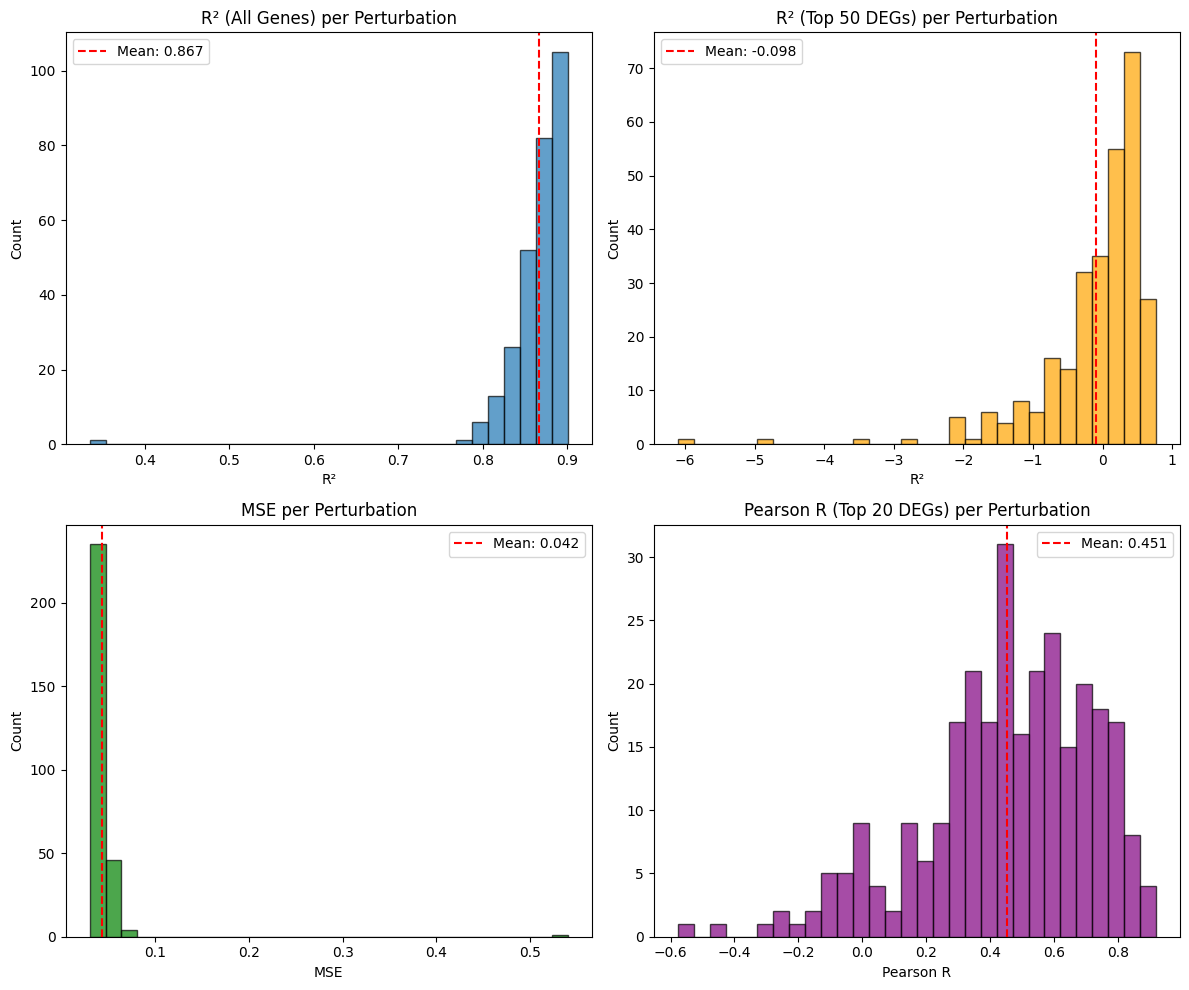

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].hist(per_pert_r2_all, bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(per_pert_r2_all.mean(), color='red', linestyle='--', label=f'Mean: {per_pert_r2_all.mean():.3f}')
axes[0, 0].set_xlabel('R²')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('R² (All Genes) per Perturbation')
axes[0, 0].legend()

axes[0, 1].hist(per_pert_r2_top50, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].axvline(per_pert_r2_top50.mean(), color='red', linestyle='--', label=f'Mean: {per_pert_r2_top50.mean():.3f}')
axes[0, 1].set_xlabel('R²')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title(f'R² (Top {TOP_K} DEGs) per Perturbation')
axes[0, 1].legend()

axes[1, 0].hist(per_pert_mse, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].axvline(per_pert_mse.mean(), color='red', linestyle='--', label=f'Mean: {per_pert_mse.mean():.3f}')
axes[1, 0].set_xlabel('MSE')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('MSE per Perturbation')
axes[1, 0].legend()

axes[1, 1].hist(per_pert_pearson_top20, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].axvline(per_pert_pearson_top20.mean(), color='red', linestyle='--', label=f'Mean: {per_pert_pearson_top20.mean():.3f}')
axes[1, 1].set_xlabel('Pearson R')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Pearson R (Top 20 DEGs) per Perturbation')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Prediction vs. Ground Truth

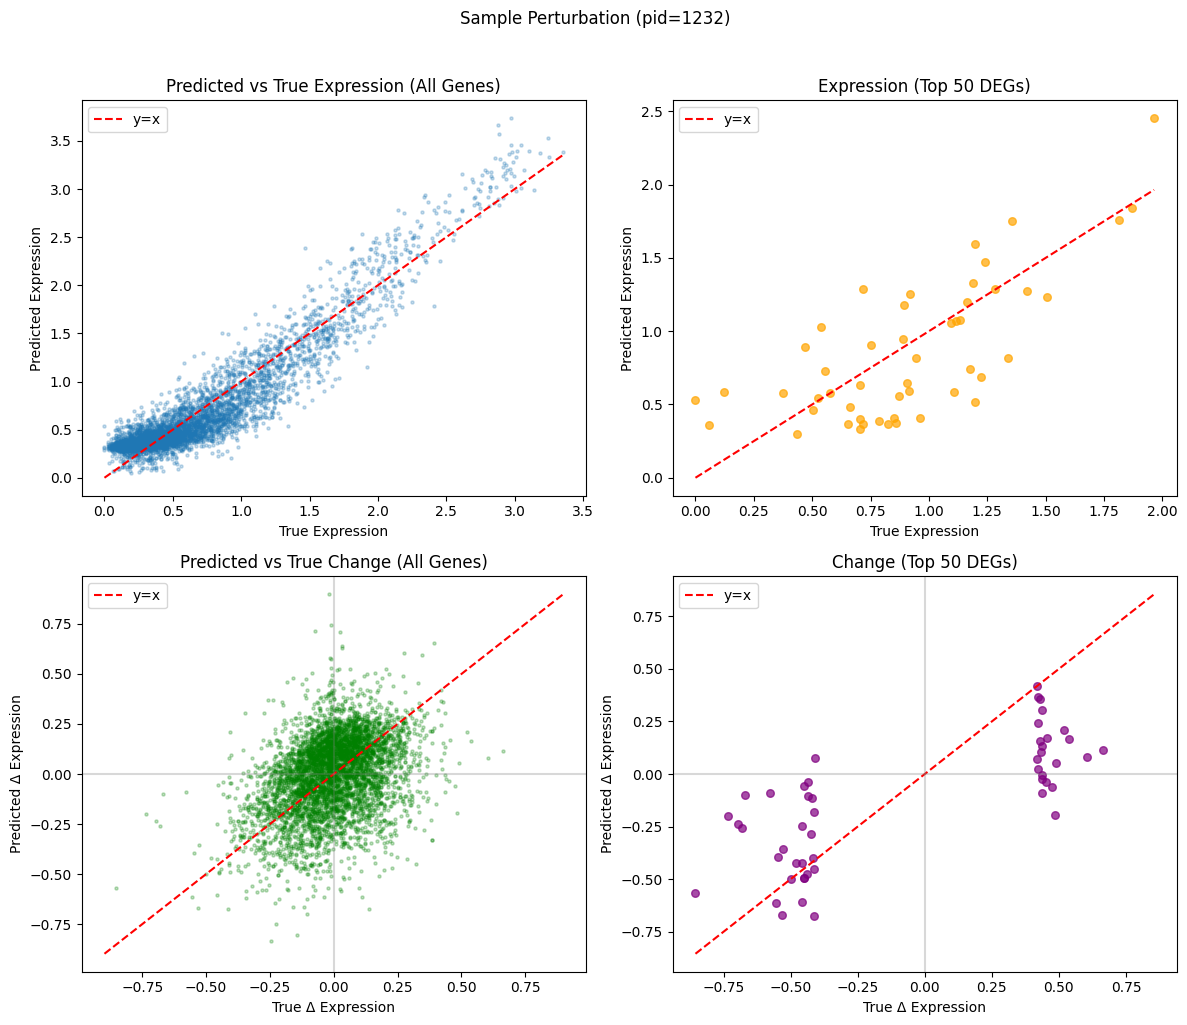

In [7]:
sample_pid = random.choice(pert_ids)
pred_abs = mean_pred_abs[sample_pid]
real_abs = mean_real_abs[sample_pid]
pred_delta = mean_pred_deltas[sample_pid]
real_delta = mean_real_deltas[sample_pid]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].scatter(real_abs, pred_abs, alpha=0.25, s=5)
axes[0, 0].plot([0, real_abs.max()], [0, real_abs.max()], 'r--', label='y=x')
axes[0, 0].set_xlabel('True Expression')
axes[0, 0].set_ylabel('Predicted Expression')
axes[0, 0].set_title('Predicted vs True Expression (All Genes)')
axes[0, 0].legend()

top_50_idx = np.argsort(np.abs(real_delta))[-50:]
axes[0, 1].scatter(real_abs[top_50_idx], pred_abs[top_50_idx], alpha=0.7, s=30, c='orange')
axes[0, 1].plot([real_abs[top_50_idx].min(), real_abs[top_50_idx].max()], 
                [real_abs[top_50_idx].min(), real_abs[top_50_idx].max()], 'r--', label='y=x')
axes[0, 1].set_xlabel('True Expression')
axes[0, 1].set_ylabel('Predicted Expression')
axes[0, 1].set_title('Expression (Top 50 DEGs)')
axes[0, 1].legend()

axes[1, 0].scatter(real_delta, pred_delta, alpha=0.25, s=5, c='green')
lim = max(abs(real_delta.min()), abs(real_delta.max()), abs(pred_delta.min()), abs(pred_delta.max()))
axes[1, 0].plot([-lim, lim], [-lim, lim], 'r--', label='y=x')
axes[1, 0].axhline(0, color='gray', linestyle='-', alpha=0.3)
axes[1, 0].axvline(0, color='gray', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel('True Δ Expression')
axes[1, 0].set_ylabel('Predicted Δ Expression')
axes[1, 0].set_title('Predicted vs True Change (All Genes)')
axes[1, 0].legend()

axes[1, 1].scatter(real_delta[top_50_idx], pred_delta[top_50_idx], alpha=0.7, s=30, c='purple')
lim_top = max(abs(real_delta[top_50_idx].min()), abs(real_delta[top_50_idx].max()), 
              abs(pred_delta[top_50_idx].min()), abs(pred_delta[top_50_idx].max()))
axes[1, 1].plot([-lim_top, lim_top], [-lim_top, lim_top], 'r--', label='y=x')
axes[1, 1].axhline(0, color='gray', linestyle='-', alpha=0.3)
axes[1, 1].axvline(0, color='gray', linestyle='-', alpha=0.3)
axes[1, 1].set_xlabel('True Δ Expression')
axes[1, 1].set_ylabel('Predicted Δ Expression')
axes[1, 1].set_title('Change (Top 50 DEGs)')
axes[1, 1].legend()

plt.suptitle(f'Sample Perturbation (pid={sample_pid})', y=1.02)
plt.tight_layout()
plt.show()

## Error Analysis by Magnitude

In [8]:
all_pred_deltas = np.concatenate([mean_pred_deltas[pid] for pid in pert_ids])
all_real_deltas = np.concatenate([mean_real_deltas[pid] for pid in pert_ids])
all_errors = all_pred_deltas - all_real_deltas
all_magnitudes = np.abs(all_real_deltas)

magnitude_bins = [0, 0.25, 0.5, 1.0, 1.5, 2.0, np.inf]
bin_labels = ['0-0.25', '0.25-0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0+']

bin_mae = []
bin_counts = []

for i in range(len(magnitude_bins) - 1):
    mask = (all_magnitudes >= magnitude_bins[i]) & (all_magnitudes < magnitude_bins[i+1])
    if mask.sum() > 0:
        bin_mae.append(np.mean(np.abs(all_errors[mask])))
        bin_counts.append(mask.sum())
    else:
        bin_mae.append(0)
        bin_counts.append(0)

print('Mean Absolute Error by Magnitude of True Change:')
for label, mae, count in zip(bin_labels, bin_mae, bin_counts):
    print(f'  {label}: MAE={mae:.4f} (n={count:,})')

Mean Absolute Error by Magnitude of True Change:
  0-0.25: MAE=0.1481 (n=1,324,724)
  0.25-0.5: MAE=0.2424 (n=93,615)
  0.5-1.0: MAE=0.4273 (n=9,608)
  1.0-1.5: MAE=0.5631 (n=957)
  1.5-2.0: MAE=1.0682 (n=991)
  2.0+: MAE=1.4869 (n=105)


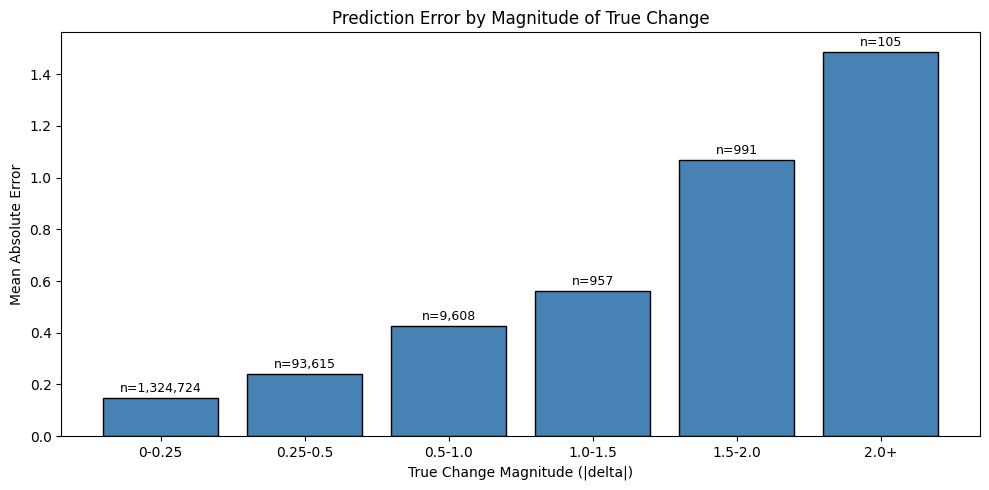

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(bin_labels))
bars = ax.bar(x, bin_mae, color='steelblue', edgecolor='black')

for bar, count in zip(bars, bin_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'n={count:,}', ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(bin_labels)
ax.set_xlabel('True Change Magnitude (|delta|)')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Prediction Error by Magnitude of True Change')

plt.tight_layout()
plt.show()

## Perturbation Severity Analysis

**Biological question**: Can the model predict how "severe" a perturbation is (magnitude of expression change)?

Severity is defined as the L2 norm of the expression delta. We compare predicted severity to actual severity.

In [10]:
from scipy.stats import spearmanr

pred_severity = np.array([np.linalg.norm(mean_pred_deltas[pid]) for pid in pert_ids])
real_severity = np.array([np.linalg.norm(mean_real_deltas[pid]) for pid in pert_ids])

severity_pearson, _ = pearsonr(pred_severity, real_severity)
severity_spearman, _ = spearmanr(pred_severity, real_severity)

print('SEVERITY PREDICTION')
print(f'  Pearson R:  {severity_pearson:.4f}')
print(f'  Spearman R: {severity_spearman:.4f}')

SEVERITY PREDICTION
  Pearson R:  0.8548
  Spearman R: 0.4789


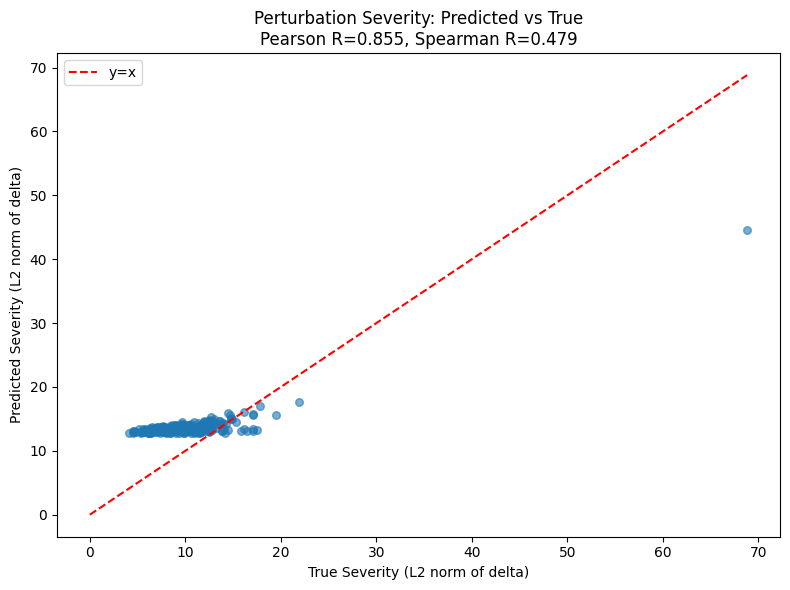

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(real_severity, pred_severity, alpha=0.6, s=30)
ax.plot([0, real_severity.max()], [0, real_severity.max()], 'r--', label='y=x')
ax.set_xlabel('True Severity (L2 norm of delta)')
ax.set_ylabel('Predicted Severity (L2 norm of delta)')
ax.set_title(f'Perturbation Severity: Predicted vs True\nPearson R={severity_pearson:.3f}, Spearman R={severity_spearman:.3f}')
ax.legend()
plt.tight_layout()
plt.show()

## Benchmark Results

In [12]:
print('='*70)
print('EVAL 1: EXPRESSION PREDICTION - BENCHMARK RESULTS')
print('='*70)
print()
print('CONFIGURATION')
print(f'  Perturbations (test): {len(pert_ids)}')
print(f'  Genes: {n_genes}')
print(f'  Test samples: {len(sample_mses):,}')
print()
print('SAMPLE-LEVEL METRICS')
print(f'  Global MSE:              {np.mean(sample_mses):.4f}')
print(f'  Top-20 DEG Pearson R:    {np.mean(sample_correlations):.4f}')
print()
print('PERTURBATION-LEVEL METRICS')
print(f'  R² (All Genes)')
print(f'    Mean:   {per_pert_r2_all.mean():.4f}')
print(f'    Median: {np.median(per_pert_r2_all):.4f}')
print(f'  R² (Top {TOP_K} DEGs)')
print(f'    Mean:   {per_pert_r2_top50.mean():.4f}')
print(f'    Median: {np.median(per_pert_r2_top50):.4f}')
print()
print('SEVERITY PREDICTION')
print(f'  Pearson R:  {severity_pearson:.4f}')
print(f'  Spearman R: {severity_spearman:.4f}')
print()
print('ERROR BY MAGNITUDE')
for label, mae, count in zip(bin_labels, bin_mae, bin_counts):
    bar = '█' * int(mae * 10)
    print(f'  {label:>8}: {mae:.3f} {bar} (n={count:,})')

EVAL 1: EXPRESSION PREDICTION - BENCHMARK RESULTS

CONFIGURATION
  Perturbations (test): 286
  Genes: 5000
  Test samples: 38,816

SAMPLE-LEVEL METRICS
  Global MSE:              0.5140
  Top-20 DEG Pearson R:    0.8711

PERTURBATION-LEVEL METRICS
  R² (All Genes)
    Mean:   0.8665
    Median: 0.8749
  R² (Top 50 DEGs)
    Mean:   -0.0982
    Median: 0.1528

SEVERITY PREDICTION
  Pearson R:  0.8548
  Spearman R: 0.4789

ERROR BY MAGNITUDE
    0-0.25: 0.148 █ (n=1,324,724)
  0.25-0.5: 0.242 ██ (n=93,615)
   0.5-1.0: 0.427 ████ (n=9,608)
   1.0-1.5: 0.563 █████ (n=957)
   1.5-2.0: 1.068 ██████████ (n=991)
      2.0+: 1.487 ██████████████ (n=105)


In [13]:
update_eval_report('eval_1_expression_prediction', {
    'config': {
        'test_perturbations': len(pert_ids),
        'genes': n_genes,
        'test_samples': len(sample_mses)
    },
    'sample_level': {
        'mse': float(np.mean(sample_mses)),
        'pearson_r_top20': float(np.mean(sample_correlations))
    },
    'perturbation_level': {
        'r2_all_genes': {'mean': float(per_pert_r2_all.mean()), 'median': float(np.median(per_pert_r2_all))},
        'r2_top50_degs': {'mean': float(per_pert_r2_top50.mean()), 'median': float(np.median(per_pert_r2_top50))},
        'mse': {'mean': float(per_pert_mse.mean()), 'median': float(np.median(per_pert_mse))}
    },
    'severity': {
        'pearson_r': float(severity_pearson),
        'spearman_r': float(severity_spearman)
    },
    'error_by_magnitude': {label: {'mae': float(mae), 'count': int(count)} for label, mae, count in zip(bin_labels, bin_mae, bin_counts)}
})

Updated eval_report.json
